In [119]:
%matplotlib inline

In [120]:
#!pip install -r requirements.txt

In [121]:
import pandas as pd
import numpy as np
import json
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor, Pool, cv as catboost_cv
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, GridSearchCV,
                                     KFold, LeaveOneOut, LeavePOut)
# --- Import scikit-learn metrics directly ---
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, r2_score, make_scorer

from scipy.stats import randint, uniform
import optuna # Added import
from imblearn.over_sampling import RandomOverSampler # Added import

# Import necessary functions from utils.py (excluding metrics)
from utils import (
    plot_pred_vs_actual_plotly,
    plot_shap_summary,
    plot_shap_waterfall,
    plot_shap_dependence,
    plot_native_feature_importance # Keep native importance plot
    # Removed RMSE, MAPE, calculate_r2 from utils import
)

In [122]:
DATA_PATH = "data/conso_data.csv"
TARGET_COLUMN = "pitd"
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Tuning settings
N_ITER_RANDOM_SEARCH = 100 # Iterations for RandomizedSearchCV
N_TRIALS_OPTUNA = 100      # Trials for Optuna optimization
CV_FOLDS_TUNING = 5       # Folds for CV during tuning

# File to save/load best parameters
PARAMS_FILENAME = 'best_catboost_params.json'

# Oversampling settings
HOLIDAY_COLUMN = 'is_holiday' # *** IMPORTANT: ASSUMING this column exists or will be created ***
ENABLE_OVERSAMPLING = False

GRID_SEARCH_POINTS = 3 # Number of points per continuous parameter in Grid Search (e.g., 3 = low, center, high)
GRID_SEARCH_RANGE_FACTOR = 0.15 

In [123]:
df = pd.read_csv("data/conso_data.csv")

In [124]:
# Calculate Heating Degree Days (HDD)
base_temp = 16.5
# Ensure 'tmoy' is numeric before calculation
df['tmoy'] = pd.to_numeric(df['tmoy'], errors='coerce')
df['hdd'] = (base_temp - df['tmoy']).clip(lower=0)

In [125]:
# Convert object to category
list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    df[str_obj_col] = df[str_obj_col].astype("category")

In [126]:
X = df.drop(columns=["pitd","target"]) #target
y = df['pitd']

In [127]:
num_variables = X.columns[X.dtypes == 'float64'].tolist()
cat_variables = X.columns[X.dtypes == 'category'].tolist()

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
features_to_quantize_names = ['pitd1', 'hdd', 'teff_cwv'] 
    
float_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
float_feature_indices = {name: i for i, name in enumerate(X_train.columns) if name in float_features}
feature_idx = {name: i for i, name in enumerate(X_train.columns)}

In [96]:
from itertools import combinations

QUANT_BORDER_CHOICES = [254, 512, 1024]

# start with None → “use global border_count or default”
quantisation_candidates = [[]]

# get only the feature‐indices we care about
feat_idxs = [
    float_feature_indices[f]
    for f in features_to_quantize_names
    if f in float_feature_indices
]

for bc in QUANT_BORDER_CHOICES:
    # 1) full list of all three
    full = [f"{i}:border_count={bc}" for i in feat_idxs]
    quantisation_candidates.append(full)

    # 2) every pair of two features
    for a, b in combinations(feat_idxs, 2):
        pair = [f"{i}:border_count={bc}" for i in (a, b)]
        quantisation_candidates.append(pair)

monotone_constraint_candidates = [
    {},  # no monotonicity
    {feature_idx["teff_cwv"]: -1},
    {feature_idx["hdd"]:      1},
    {feature_idx["teff_cwv"]: -1,
     feature_idx["hdd"]:      1},
]

In [75]:
params_filename = 'best_RS_mon_gold.json'

In [97]:
if os.path.exists(params_filename):

    cb_estimator = CatBoostRegressor(cat_features=cat_variables, verbose = 0)
    param_dist = {
        'iterations': randint(1000, 2500),
        'learning_rate': uniform(0.01, 0.2),
        'depth': randint(2, 8),
        'l2_leaf_reg': uniform(1, 5),
        'border_count': randint(126, 256),
        'per_float_feature_quantization': quantisation_candidates,
        'monotone_constraints':             monotone_constraint_candidates,
    }


    random_search = RandomizedSearchCV(
        estimator=cb_estimator,
        param_distributions=param_dist,
        n_iter=N_ITER_RANDOM_SEARCH,
        scoring='neg_root_mean_squared_error',
        cv = 5,
        error_score = 'raise',
        n_jobs=1,
        verbose=1,
        random_state=RANDOM_STATE
    )


    best_params_random = {}
    best_score_rs = -np.inf
    final_model_rs = None
    rs_model_metrics = {'RMSE': np.inf, 'MAPE': np.inf, 'R2': -np.inf}
    try:
        random_search.fit(X_train, y_train, early_stopping_rounds = 20)
        if hasattr(random_search, 'best_params_'):
            best_params_random = random_search.best_params_
            best_score_rs = random_search.best_score_
            print(f"Best Internal CV Score (Negative RMSE): {best_score_rs:.4f}")
            print(f"Equivalent Best RMSE: {-best_score_rs:.4f}")
            print(json.dumps(best_params_random, indent=4))

            with open(params_filename, 'w') as f:
                json.dump(best_params_random, f, indent=4) 
        else:
            print("Randomized Search did not find best parameters.")
    except Exception as e:
        print(f"\nError during Randomized Search fit: {e}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Internal CV Score (Negative RMSE): -16657.2953
Equivalent Best RMSE: 16657.2953
{
    "border_count": 200,
    "depth": 3,
    "iterations": 1750,
    "l2_leaf_reg": 1.7149584102641793,
    "learning_rate": 0.16230212634349447,
    "monotone_constraints": {
        "16": -1,
        "58": 1
    },
    "per_float_feature_quantization": []
}


In [98]:
with open(params_filename, 'r') as f:
    best_params_random = json.load(f)

In [99]:
final_model_rs = CatBoostRegressor(cat_features=cat_variables, loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE, **best_params_random)
final_model_rs.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=0, plot=True) 
print("\n--- Randomized Search Final Model Evaluation ---")
final_model_rs.save_model(
    "models/RS_model_mon_gold.cbm"    
)
y_pred_rs = final_model_rs.predict(X_test)
rmse_rs = root_mean_squared_error(y_test, y_pred_rs)
mape_rs = mean_absolute_percentage_error(y_test, y_pred_rs) * 100
r2_rs = r2_score(y_test, y_pred_rs)
print(f"Test RMSE: {rmse_rs:.2f}, MAPE: {mape_rs:.2f}%, R2: {r2_rs:.4f}")
rs_model_metrics = {'RMSE': rmse_rs, 'MAPE': mape_rs, 'R2': r2_rs}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


--- Randomized Search Final Model Evaluation ---
Test RMSE: 23420.41, MAPE: 9.09%, R2: 0.9892


In [106]:
N_TRIALS_OPTUNA_FOCUSED = 1000
center_iterations = best_params_random.get('iterations', 1000)
center_lr = best_params_random.get('learning_rate', 0.05)
center_depth = best_params_random.get('depth', 6)
center_l2 = best_params_random.get('l2_leaf_reg', 3)
center_border = best_params_random.get('border_count', 128)
def objective_focused(trial):
    quant_idx  = trial.suggest_int("quant_idx",  0, len(quantisation_candidates) - 1)
    mono_idx   = trial.suggest_int("mono_idx",   0, len(monotone_constraint_candidates) - 1)
    param = {
        'objective': 'RMSE', 'loss_function': 'RMSE', 'eval_metric': 'RMSE',
        'random_seed': RANDOM_STATE, 'cat_features': cat_variables,
        'verbose': 0, 'early_stopping_rounds': 50,

        'iterations': trial.suggest_int('iterations', int(max(100, center_iterations * (1 - GRID_SEARCH_RANGE_FACTOR*1.5))), int(center_iterations * (1 + GRID_SEARCH_RANGE_FACTOR*1.5))), # Slightly wider range than GS
        'learning_rate': trial.suggest_float('learning_rate', max(0.001, center_lr * (1 - GRID_SEARCH_RANGE_FACTOR*1.5)), center_lr * (1 + GRID_SEARCH_RANGE_FACTOR*1.5), log=True),
        'depth': trial.suggest_int('depth', max(2, center_depth - 1), center_depth + 1), # Tight range around best depth
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', max(0.01, center_l2 * (1 - GRID_SEARCH_RANGE_FACTOR*1.5)), center_l2 * (1 + GRID_SEARCH_RANGE_FACTOR*1.5), log=True),
        'border_count': trial.suggest_int('border_count', int(max(32, center_border * (1 - GRID_SEARCH_RANGE_FACTOR*1.5))), int(min(255, center_border * (1 + GRID_SEARCH_RANGE_FACTOR*1.5)))),

        'per_float_feature_quantization': quantisation_candidates[quant_idx],
        'monotone_constraints':            monotone_constraint_candidates[mono_idx],}

    cv = KFold(n_splits=CV_FOLDS_TUNING, shuffle=True, random_state=RANDOM_STATE)
    rmses = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]
        # Optional Oversampling (inside fold)
        if ENABLE_OVERSAMPLING and HOLIDAY_COLUMN in X_t.columns: pass # Placeholder
        try:
            model_cv = CatBoostRegressor(**param)
            model_cv.fit(X_t, y_t, eval_set=[(X_v, y_v)])
            preds = model_cv.predict(X_v)
            fold_rmse = root_mean_squared_error(y_v, preds)
            rmses.append(fold_rmse)
        except Exception as e:
             print(f"Warning: Optuna trial fold {fold+1} failed: {e}")
             return np.inf 
    if not rmses: return np.inf
    return np.mean(rmses)

study_focused = optuna.create_study(direction='minimize')
print(f"Running Focused Optuna study for {N_TRIALS_OPTUNA_FOCUSED} trials...")
study_focused.optimize(objective_focused, n_trials=N_TRIALS_OPTUNA_FOCUSED)

print("Focused Optuna Optimization Finished.")
best_params_optuna_focused = {}
best_value_optuna_focused = np.inf
final_model_optuna_focused = None
optuna_focused_model_metrics = {'RMSE': np.inf, 'MAPE': np.inf, 'R2': -np.inf}

if study_focused.best_trial:
    trial_focused = study_focused.best_trial
    best_value_optuna_focused = trial_focused.value
    print(f"  Value (RMSE): {best_value_optuna_focused:.4f}")
    print("  Best Parameters Found by Focused Optuna: ")
    best_params_optuna_focused = trial_focused.params

    print(json.dumps(best_params_optuna_focused, indent=4))
    with open('best_params_opt_gold_mon.json', "w") as f:
        json.dump(best_params_optuna_focused,f, indent=4)
else:
     print("Focused Optuna study did not complete successfully or found no best trial.")


[I 2025-04-22 23:02:55,573] A new study created in memory with name: no-name-6ca29ed5-c880-4268-97e9-ea2225d72f9c


Running Focused Optuna study for 1000 trials...


[I 2025-04-22 23:03:03,355] Trial 0 finished with value: 20641.664263739145 and parameters: {'quant_idx': 5, 'mono_idx': 3, 'iterations': 2115, 'learning_rate': 0.18458616007990628, 'depth': 2, 'l2_leaf_reg': 1.618095070441799, 'border_count': 232}. Best is trial 0 with value: 20641.664263739145.
[I 2025-04-22 23:03:16,283] Trial 1 finished with value: 19221.98990148749 and parameters: {'quant_idx': 7, 'mono_idx': 0, 'iterations': 1680, 'learning_rate': 0.17709326799423963, 'depth': 4, 'l2_leaf_reg': 1.831769123821084, 'border_count': 155}. Best is trial 1 with value: 19221.98990148749.
[I 2025-04-22 23:03:25,179] Trial 2 finished with value: 19348.491159711597 and parameters: {'quant_idx': 4, 'mono_idx': 3, 'iterations': 1714, 'learning_rate': 0.14309860815586703, 'depth': 2, 'l2_leaf_reg': 1.7750382900074215, 'border_count': 230}. Best is trial 1 with value: 19221.98990148749.
[I 2025-04-22 23:03:37,405] Trial 3 finished with value: 18222.290020746572 and parameters: {'quant_idx': 2,

Focused Optuna Optimization Finished.
  Value (RMSE): 17317.5428
  Best Parameters Found by Focused Optuna: 
{
    "quant_idx": 6,
    "mono_idx": 0,
    "iterations": 1624,
    "learning_rate": 0.13442522841814547,
    "depth": 3,
    "l2_leaf_reg": 2.0280138788298303,
    "border_count": 198
}


In [107]:
with open('best_params_opt_gold_mon.json', "r") as f:
        best_params_optuna_focused= json.load(f)
quant_idx = best_params_optuna_focused.pop("quant_idx")
mono_idx  = best_params_optuna_focused.pop("mono_idx")

# 2) map back into your pre-built lists
best_params_optuna_focused["per_float_feature_quantization"] = quantisation_candidates[quant_idx]
best_params_optuna_focused["monotone_constraints"]            = monotone_constraint_candidates[mono_idx]
print(best_params_optuna_focused)
final_model_optuna_focused = CatBoostRegressor(
    cat_features=cat_variables, loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE, **best_params_optuna_focused)
final_model_optuna_focused.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=200, verbose=0, plot=True)
final_model_optuna_focused.save_model(
    "models/focused_optuna_model_no_target.cbm"    # filename
)
print("\n--- Focused Optuna Final Model Evaluation ---")
y_pred_optuna_focused = final_model_optuna_focused.predict(X_test)
rmse_optuna_focused = root_mean_squared_error(y_test, y_pred_optuna_focused)
mape_optuna_focused = mean_absolute_percentage_error(y_test, y_pred_optuna_focused) * 100
r2_optuna_focused = r2_score(y_test, y_pred_optuna_focused)
print(f"Test RMSE: {rmse_optuna_focused:.2f}, MAPE: {mape_optuna_focused:.2f}%, R2: {r2_optuna_focused:.4f}")
optuna_focused_model_metrics = {'RMSE': rmse_optuna_focused, 'MAPE': mape_optuna_focused, 'R2': r2_optuna_focused}


{'iterations': 1624, 'learning_rate': 0.13442522841814547, 'depth': 3, 'l2_leaf_reg': 2.0280138788298303, 'border_count': 198, 'per_float_feature_quantization': ['4:border_count=512', '58:border_count=512'], 'monotone_constraints': {}}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


--- Focused Optuna Final Model Evaluation ---
Test RMSE: 16593.47, MAPE: 4.13%, R2: 0.9946



--- Overall Model Comparison & Analysis (with CV Evaluation) ---
Using 10-Fold Cross-Validation for model evaluation metrics.
Loaded 'Baseline', running CatBoost.cv …
Training on fold [0/10]

bestTest = 17898.25631
bestIteration = 992

Training on fold [1/10]

bestTest = 16618.87785
bestIteration = 996

Training on fold [2/10]

bestTest = 15046.53234
bestIteration = 998

Training on fold [3/10]

bestTest = 17355.29936
bestIteration = 999

Training on fold [4/10]

bestTest = 19411.14426
bestIteration = 998

Training on fold [5/10]

bestTest = 17910.2424
bestIteration = 996

Training on fold [6/10]

bestTest = 18963.38034
bestIteration = 987

Training on fold [7/10]

bestTest = 19341.5854
bestIteration = 994

Training on fold [8/10]

bestTest = 18881.16162
bestIteration = 998

Training on fold [9/10]

bestTest = 17164.58234
bestIteration = 998

  → Baseline: RMSE=17863.7733, MAPE=4.72%, R²=0.9938
Loaded 'TimeAware', running CatBoost.cv …
Training on fold [0/10]

bestTest = 18287.89148
b

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  Could not compare Baseline vs TimeAware: 'NoneType' object is not subscriptable

Comparing 'Baseline' vs 'Golden' on Test Set…


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  Could not compare Baseline vs Golden: 'NoneType' object is not subscriptable

Comparing 'Baseline' vs 'RS_tuned' on Test Set…


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  Could not compare Baseline vs RS_tuned: 'NoneType' object is not subscriptable

Comparing 'Baseline' vs 'optuna' on Test Set…


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  Could not compare Baseline vs optuna: 'NoneType' object is not subscriptable

Comparing 'TimeAware' vs 'Golden' on Test Set…


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  Could not compare TimeAware vs Golden: 'NoneType' object is not subscriptable

Comparing 'TimeAware' vs 'RS_tuned' on Test Set…


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  Could not compare TimeAware vs RS_tuned: 'NoneType' object is not subscriptable

Comparing 'TimeAware' vs 'optuna' on Test Set…


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  Could not compare TimeAware vs optuna: 'NoneType' object is not subscriptable

Comparing 'Golden' vs 'RS_tuned' on Test Set…


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  Could not compare Golden vs RS_tuned: 'NoneType' object is not subscriptable

Comparing 'Golden' vs 'optuna' on Test Set…


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  Could not compare Golden vs optuna: 'NoneType' object is not subscriptable

Comparing 'RS_tuned' vs 'optuna' on Test Set…


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  Could not compare RS_tuned vs optuna: 'NoneType' object is not subscriptable


--- Final Model Analysis (Overall Best based on CV Metrics) ---
Selected 'RS_tuned' as best model (lowest Mean CV RMSE).

Analyzing model: None

Plotting native feature importance...
Native importance plot generation skipped for Azure ML script.

Generating SHAP plots...


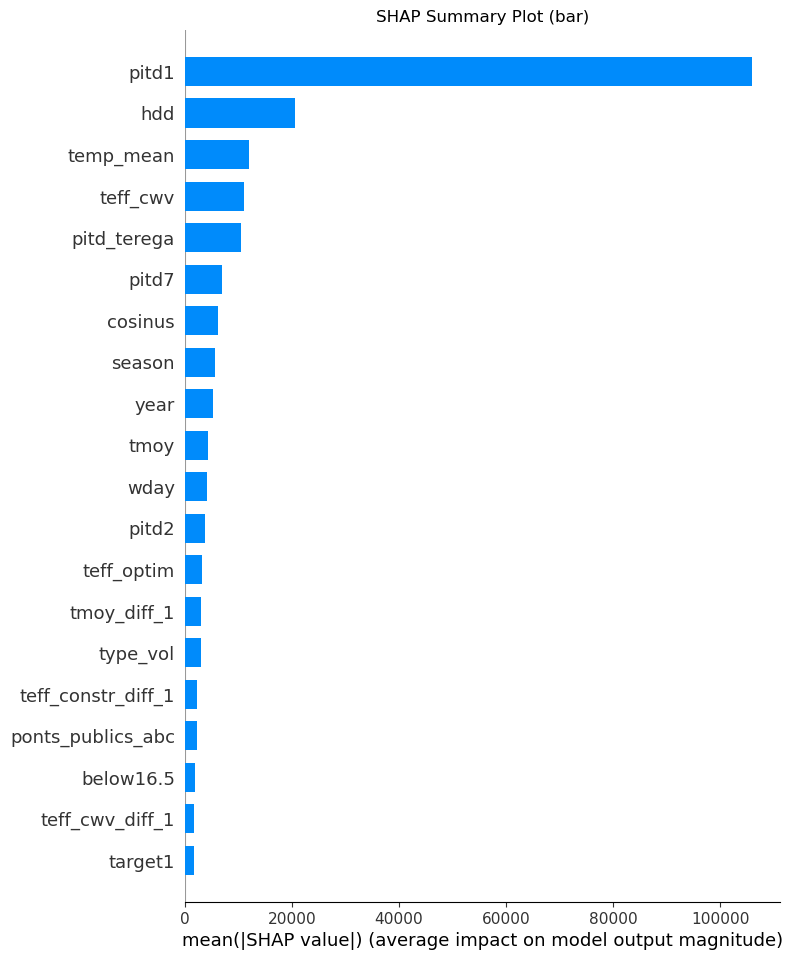

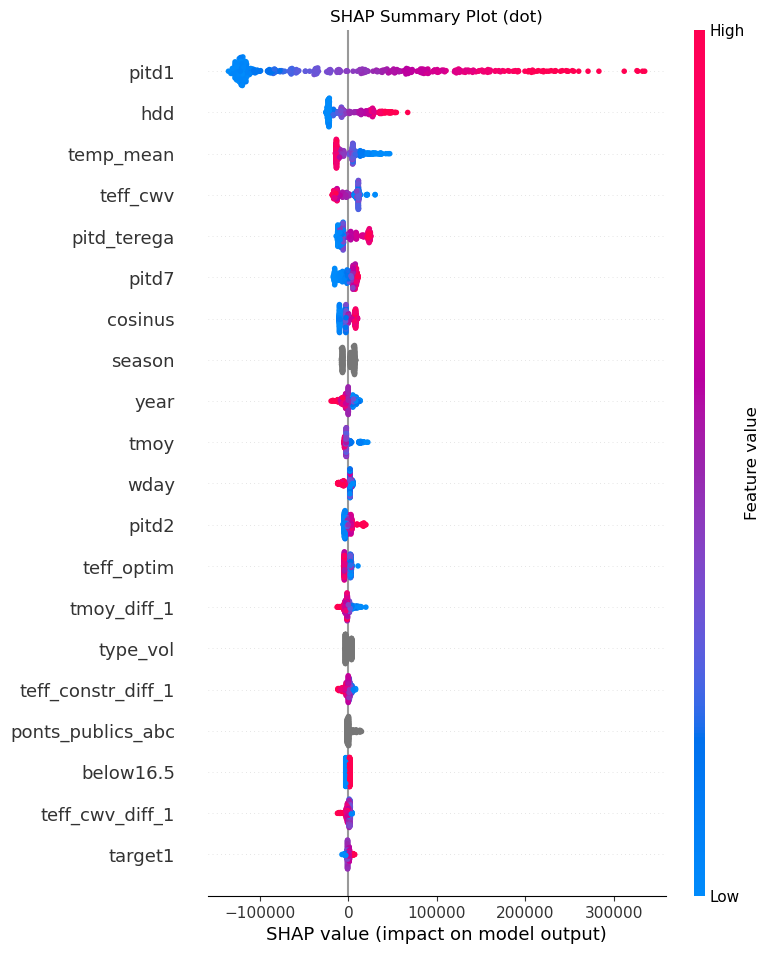

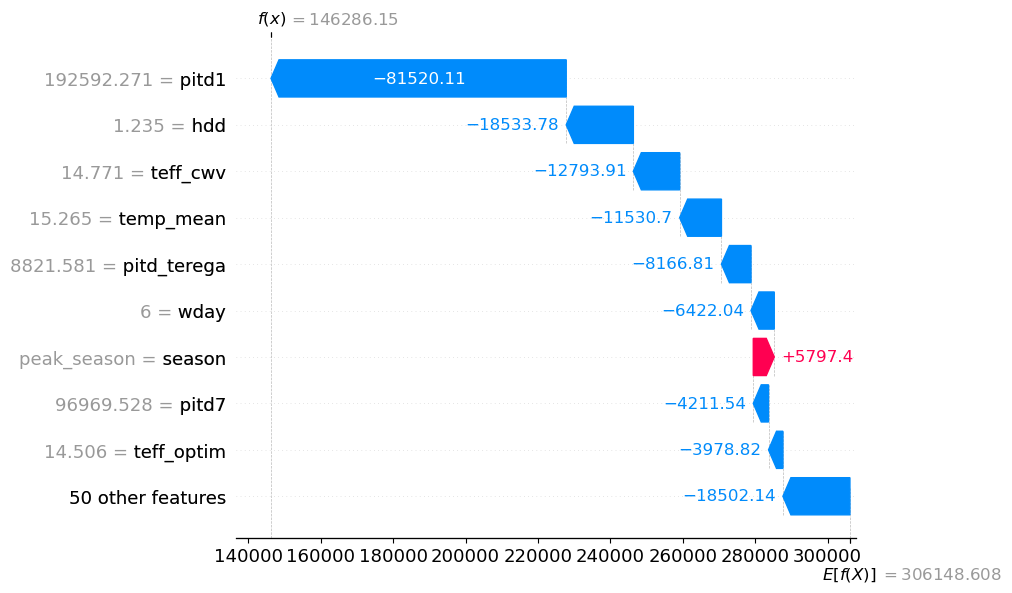

SHAP plot generation skipped for Azure ML script.

Script section finished.


In [136]:
print("\n" + "="*50)
print("--- Overall Model Comparison & Analysis (with CV Evaluation) ---")

# Imports for CV and metrics
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, root_mean_squared_error, mean_absolute_percentage_error, r2_score
from catboost import CatBoostRegressor, Pool, cv as catboost_cv # Ensure Pool is imported
import numpy as np
import pandas as pd
import os # Ensure os is imported


# 1) Convert your datetimes to strings
X_train['date'] = X_train['date'].astype(str)
X_test ['date'] = X_test ['date'].astype(str)

# 2) Define the full list of categorical features (including date)
cat_features = ['date'] + [c for c in cat_variables if c != 'date']

# 3) Build a single Pool over your training data with cat_features
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)

# --- Define CV strategy ---------------------------------------------
N_CV_EVAL_FOLDS = 10
print(f"Using {N_CV_EVAL_FOLDS}-Fold Cross-Validation for model evaluation metrics.")

# --- Load models and run CatBoost’s native cv() ---------------------
models_to_load_paths = {
    "Baseline": 'models/cb_base_model.cbm',
    "TimeAware": 'models/cb_time_model.cbm',
    "Golden":    'models/cb_golden_model.cbm',
    "RS_tuned":  'models/RS_model_mon_gold.cbm',
    "optuna":    'models/focused_optuna_model_no_target.cbm'
}

model_cv_metrics = {}
for name, path in models_to_load_paths.items():
    try:
        # load the model hyper-params
        m = CatBoostRegressor()
        m.load_model(path)
        print(f"Loaded '{name}', running CatBoost.cv …")

        # grab the params and inject eval_metric + custom_metric
        params = m.get_params()
        # primary metric = RMSE (matches your loss_function), extras = MAPE and R2
        params['eval_metric']   = 'RMSE'
        params['custom_metric'] = ['MAPE','R2']

        # run the 10-fold CV
        cv_df = catboost_cv(
            pool=train_pool,
            params=params,
            fold_count=N_CV_EVAL_FOLDS,
            partition_random_seed=RANDOM_STATE,
            shuffle=True,
            as_pandas=True,
            verbose=False
        )
        # cv_df columns include:
        #   'iterations',
        #   'test-RMSE-mean', 'test-RMSE-std',
        #   'test-MAPE-mean','test-MAPE-std',
        #   'test-R2-mean','test-R2-std', etc.

        # 2) Pull out the final means from the last row:
        mean_rmse = cv_df['test-RMSE-mean'].iloc[-1]
        mean_mape = cv_df['test-MAPE-mean'].iloc[-1] * 100     # percent
        mean_r2   = cv_df['test-R2-mean'].iloc[-1]

        model_cv_metrics[name] = {
            'RMSE': mean_rmse,
            'MAPE': mean_mape,
            'R2':   mean_r2
        }
        print(f"  → {name}: RMSE={mean_rmse:.4f}, MAPE={mean_mape:.2f}%, R²={mean_r2:.4f}")

    except Exception as e:
        print(f"Error evaluating '{name}': {e}. Skipping.")


print("\nCombining all models for comparison...")
all_models_to_compare = loaded_models.copy() 

# --- Create Metrics DataFrame (using MEAN CV metrics) ---
print("\nCreating final metrics comparison table using Mean CV Scores...")
if not model_cv_metrics:
     print("Warning: No model CV metrics available for comparison table.")
     comparison_df_all = pd.DataFrame() # Empty DataFrame
else:
    # build DataFrame and keep only RMSE/ MAP E/ R2
    comparison_df_all = pd.DataFrame(model_cv_metrics).T
    cols_to_show = [c for c in ['RMSE','MAPE','R2'] if c in comparison_df_all.columns]
    comparison_df_all = comparison_df_all[cols_to_show]
    print("\nCombined Model Performance Comparison (Mean CV Scores on Training Data):")
    print(comparison_df_all.sort_values('RMSE').to_string(float_format="%.4f"))
    
    # save JSON
    METRICS_FILENAME = 'final_metrics.json'
    print(f"Saving final CV metrics comparison to {METRICS_FILENAME}...")
    comparison_df_all.to_json(METRICS_FILENAME, indent=4, orient="index")

# --- Run CatBoost `.compare()` on the TEST SET ---
# Note: .compare() still uses the single test split for direct comparison
print("\n--- Comparing CatBoost Models using model.compare() on Test Set ---")

    # Create comparison pool using the original TEST set

X_test['date'] = X_test['date'].astype(str)
comparison_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)
model_names = list(all_models_to_compare.keys())
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        n1, n2 = model_names[i], model_names[j]
        m1 = all_models_to_compare[n1]
        m2 = all_models_to_compare[n2]
        print(f"\nComparing '{n1}' vs '{n2}' on Test Set…")
        try:
            comp_df = m1.compare(
                m2,
                comparison_pool,
                metrics=['RMSE']     # you can also add 'MAPE','R2' here if desired
            )
            print(comp_df[['metric_name','model1_wins','model2_wins','metric_value_diff']])
        except Exception as e:
            print(f"  Could not compare {n1} vs {n2}: {e}")
print("="*50 + "\n")


# --- Final Model Analysis (Choose Overall Best based on CV Metrics Table) ---
print("\n--- Final Model Analysis (Overall Best based on CV Metrics) ---")
final_model_to_analyze = None
best_model_name = None

# Use the comparison_df_all which now contains CV metrics
if not comparison_df_all.empty:
     try:
        best_name = comparison_df_all['RMSE'].idxmin()
        print(f"Selected '{best_name}' as best model (lowest Mean CV RMSE).")
        final_model_to_analyze = all_models_to_compare[best_name]
     except Exception as e:
          print(f"Could not determine best model from CV metrics table: {e}")

# Analyze the selected best model (trained on full training data)
if final_model_to_analyze and final_model_to_analyze.is_fitted():
    print(f"\nAnalyzing model: {best_model_name}")
    # Feature Importance (using the model trained on full X_train)
    print("\nPlotting native feature importance...")
    if 'X_train' in locals() and hasattr(X_train, 'columns'):
        final_feature_names = X_train.columns.tolist()
        # Assuming plot_native_feature_importance is available from utils
        # You might want to disable plotting in Azure ML jobs or save plots to output dir
        try:
             from utils import plot_native_feature_importance
             # plot_native_feature_importance(final_model_to_analyze, final_feature_names) # Comment out plt.show() in utils for Azure ML
             print("Native importance plot generation skipped for Azure ML script.")
        except ImportError:
             print("Could not import plot_native_feature_importance from utils.")
    else:
        print("Warning: Cannot get feature names for native importance plot.")

    # SHAP Analysis (Optional - can be computationally expensive)
    print("\nGenerating SHAP plots...")
    if 'X_test' in locals() and 'final_feature_names' in locals():
        try:
            from utils import plot_shap_summary, plot_shap_waterfall
            plot_shap_summary(final_model_to_analyze, X_test, final_feature_names, plot_type="bar") # Comment out plt.show()
            plot_shap_summary(final_model_to_analyze, X_test, final_feature_names, plot_type="dot") # Comment out plt.show()
            plot_shap_waterfall(final_model_to_analyze, X_test, final_feature_names, instance_index=1) # Comment out plt.show()
            print("SHAP plot generation skipped for Azure ML script.")
        except ImportError:
             print("Could not import SHAP plotting functions from utils.")
    else:
        print("Warning: Cannot generate SHAP plots (X_test or feature names not available?).")
else:
    print("No final best model available for analysis (either none found or selection failed).")

print("\n" + "="*50)
print("Script section finished.")
# %%
